## Analysis of the substitution LBI distributions 

- [General](#general)
- [Analysis functions](#analysis-functions)
- [Data exploration](#data-explanation)
  - [sequence origin](#sequence-origin)
- [Mutation frequency trajectory](#mutation-frequency-trajectory)
  - [plot](#mutation-frequency-trajectory-plot)
- [Mutation LBI distribution per season per analysis](#mutation-lbi-distribution-per-season-per-analysis)
- [Statistical analysis](#statistical-analysis-of-the-mutation-lbi-distributions)
  - [plot](#statistical-results-plot)
- [LBI distribution visualization](#lbi-distribution-visualization)

### General

In [1]:
import os, dendropy, math, sys,itertools
import pandas as pd, numpy as np, statistics as st
import scipy.stats as stats
import scikit_posthocs as sp
from collections import OrderedDict, Counter
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.cm import register_cmap
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
import matplotlib.colorbar as mcp

sns.set_theme(style="white", font="Arial")
sns.set_context({'font.size': 10.0, 'axes.labelsize': 'medium', 'axes.titlesize': 'medium',
                 'xtick.labelsize': 'small', 'ytick.labelsize': 'small', 'legend.fontsize': 'small',
                 'legend.title_fontsize': None, 'axes.linewidth': 0.8, 'grid.linewidth': 0.8,
                 'lines.linewidth': 1.5, 'lines.markersize': 6.0, 'patch.linewidth': 1.0,
                 'xtick.major.width': 0.5, 'ytick.major.width': 0.5, 'xtick.minor.width': 0.3,
                 'ytick.minor.width': 0.3, 'xtick.major.size': 3.5, 'ytick.major.size': 3.5,
                 'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,})

#color palettes
base_color = "#B6B8B9"

In [2]:
#epitope sites
epitope_sites = {"A":[122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146], 
                 "B":[155,156,157,158,159,160,186,187,188,189,190,191,192,193,194,195,196,197,198], 
                 "C":[44,45,46,47,48,49,50,51,52,53,54,274,275,276,277,278,279,280,281], 
                 "D":[201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220], 
                 "E":[78,79,80,81,82,83,84,85,86,87,89,90,91,92,93,94,261,262,263,264,265,266]}

epitope_positions =[site for site in epitope_sites.values()]
epitope_positions = sorted([pos for pos_list in epitope_positions for pos in pos_list])

In [3]:
#egg passaged mutations
major_egg_passaged_mutations = ["H156Q", "H156R", "H183L", "G186V", "L194P", "S219Y","S219F", "N246H", "N246S"]
minor_egg_passaged_mutations = ["T160K", "H183L", "A196T", "H183L", "A196T"]

In [4]:
#set cutoff definitions for minor mutation and fixed mutations
minor_cutoff = 0.05
fixed_cutoff = 0.95

### Analysis functions
Created functions for reproducibility as well as efficiently. Not in utils because I didn't want to reload the kernel every time I made a change.

In [5]:
#returns seasons, mature_sequences, trees
def get_sequences_trees_seasons(file_dir):
    """
    get the mature sequences and trees per season from the subset files in the input directory
    input:
        - file_dir: directory where analysis files per season are stored
    output:
        - seasons: list of all seasons in the data set, chronologically sorted
        - mature_sequences: dict with mature sequences per season (list with Bio records)
        - trees: dict with phylogenetic trees per season (dendropy tree objects)
    """
    sequences = get_sequence_files(file_dir)
    sequences = dict(OrderedDict(sorted(sequences.items())))
    trees = get_tree_files_per_season(file_dir) 

    mature_sequences = {} #only interested in the mature HA protein 
    sequence_ids = {} #and some times even only in the ID only
    for season, seqs in sequences.items():
        mature  = get_mature_HA_sequences(seqs)
        mature_sequences[season] = mature
        sequence_ids[season] = [r.id for r in seqs]

    seasons = list(mature_sequences.keys())
    return seasons, mature_sequences, trees

#returns mutation_freqs
def get_mutation_frequency_trajectories(mature_sequences):
    """
    get the frequency trajectories of all mutations in mature_sequences
    input:
        - mature_sequences: dict with mature sequences per season (list with Bio records)
    output:
        - matutation_freqs: Pandas dataframe rows mutation columns season > values frequency 
    """
    #determine all the potential variants and get the frequencies of these variants over the seasons
    variants = get_variants(mature_sequences)

    var_frequencies = {} #get the frequencies per variant per season
    pos_var = {} #get variants per positions 
    for var in variants:
        var_frequencies[var] = {}
        for season, seqs in mature_sequences.items():
            var_frequencies[var][season] = round(float(determine_var_frequency(var,seqs)),3)
        pos = int("".join(var[:-1]))
        try:
            pos_var[pos].append(var)
        except:
            pos_var[pos] = [var]

    #make a DataFrame of variant frequencies 
    variant_freqs = pd.DataFrame.from_dict(var_frequencies, orient="index").reset_index(level=0).rename(columns={"index":"variant"})

    #translate variants into mutations 
    var_mut = {}
    for pos, v in pos_var.items():
        if len(v) > 1:
            posdf = variant_freqs[variant_freqs["variant"].isin(v)]
            #get variant with the highest frequency the first season
            leading_variant = posdf[posdf[seasons[0]]==max(posdf[seasons[0]])]["variant"].values[0]
            original_aa = leading_variant[-1]

            #get the mutations assuming that the leading variants is the initial AA
            for variant in posdf["variant"]:
                if variant != leading_variant:
                    var_mut[variant] = original_aa + variant

    mutation_freqs = variant_freqs[variant_freqs['variant'].isin(var_mut.keys())].copy().reset_index(drop=True)
    #add mutation as a column to the DataFrame
    mutation_freqs["mutation"] = ""
    for i, row in mutation_freqs.iterrows():
        mutation_freqs.iloc[i, mutation_freqs.columns.get_loc("mutation")] = var_mut[row["variant"]]

    mutation_freqs = mutation_freqs[["variant", "mutation"]+seasons]

    #remove the minor mutations from the analysis > don't reach frequencies higher than 5% over all seasons
    to_drop = []
    for mutation in mutation_freqs["mutation"].unique():
        freqs = {s:v[0] for s,v in mutation_freqs[mutation_freqs["mutation"]==mutation][seasons].to_dict(orient="list").items()}

        if all(freq < minor_cutoff for freq in freqs.values()):
            to_drop.append(mutation)
        
    mutation_freqs = mutation_freqs[~mutation_freqs["mutation"].isin(to_drop)].reset_index(drop=True).drop(["variant"], axis=1)

    return mutation_freqs

#returns mutation_timepoints, mutation_groups
def time_point_assignment(mutation_freqs, f0, seasons):
    """
    get the timepoints in which mutations exceed f0 and at which they first appear
    differentiating between mutation reach/exceed f0 in their first season
    also assign mutations to groups 
    input:
        - mutation_freqs: Pandas dataframe rows mutation columns season > values frequency 
        - f0: float with separation frequency
        - seasons: list of all seasons in the data set, chronologically sorted
    output:
        - mutation_timepoints: Pandas dataframe, with mutations and their assigned timepoints and group
        - mutation_group: dict {mutation_group:[mutations]}
    """
    #create new data frame with group, and time point columns
    mutation_timepoints = pd.DataFrame({"mutation":mutation_freqs["mutation"].copy()})
    mutation_timepoints[["group", "t0", "tf0", "tfmax"]] = ""

    #determine group, and time points for all mutations
    mutation_groups = {"A":[], "B":[], "C":[]}
    for i, row in mutation_timepoints.iterrows():
        mutation = row["mutation"]

        #get the frequencies per season from mutation_freqs
        freqs = {season:mutation_freqs[mutation_freqs["mutation"]==mutation][season].values[0] for season in seasons}
        #determine if the mutation reaches or exceeds f0
        if any(freq >= f0 for freq in freqs.values()):

            #determine the season in which f0 is reached/exceeded
            for season, freq in freqs.items():
                if freq >= f0:
                    tf0 = season 
                    break
            
            #determine the season preceeding tf0 during which the mutation made it's first appearance (above minor cutoff), continuously
            for season in reversed(seasons[:seasons.index(tf0)+1]):
                if freqs[season] >= minor_cutoff:
                    t0 = season
                else:
                    break
            
            #only assigning t0 is if t0 != tf0 > else pop-up
            if t0 == tf0:
                t0 = "pop-up"

            #determine if the mutation eventually fixes and assign groups 
            if any(freqs[season]>=fixed_cutoff for season in seasons[seasons.index(tf0):]):
                group = "A"
            else:
                group = "B"
            
            tfmax = "not relevant"
            
        else: #mutation never reaches f0
            tf0 = "never"
            group = "C"

            #determine t0 which is the season preceeding tfmax > the season maximum frequency is reached
            tfmax = seasons[list(freqs.values()).index(max(freqs.values()))]
            for season in reversed(seasons[:seasons.index(tfmax)+1]):
                if freqs[season] >= minor_cutoff:
                    t0 = season
                else:
                    break

        mutation_groups[group].append(mutation)

        #assign values to dataframe
        mutation_timepoints.iloc[i, mutation_timepoints.columns.get_loc("group")] = group
        mutation_timepoints.iloc[i, mutation_timepoints.columns.get_loc("t0")] = t0
        mutation_timepoints.iloc[i, mutation_timepoints.columns.get_loc("tf0")] = tf0
        mutation_timepoints.iloc[i, mutation_timepoints.columns.get_loc("tfmax")] = tfmax

    return mutation_timepoints, mutation_groups

#return mutation_info
def get_additional_info(mutation_freqs):
    """
    determine whether mutation is located in epitope sites, or rbs:
    input:
        - mutation_freqs: Pandas dataframe rows mutation columns season > values frequency 
    output:
        - mutation_info: Pandas dataframe with the mutations from mutation freqs and the additonal info
    """
    #create dataframe with additional information
    mutation_info = pd.DataFrame({"mutation":mutation_freqs["mutation"].copy()})
    mutation_info[['epitope site', 'RBS']] = bool()
    mutation_info[['epitope']] = ''

    for i, row in mutation_info.iterrows():
        mutation = row["mutation"]
        position = int("".join(mutation[1:-1]))

        #check if mutation is located in epitope site, if so in which
        if position in epitope_positions:
            mutation_info.iloc[i, mutation_info.columns.get_loc("epitope site")] = True
            epitope_site = [epitope for epitope, sites in epitope_sites.items() if position in sites][0]
            mutation_info.iloc[i, mutation_info.columns.get_loc("epitope")] = epitope_site
        
        #check if mutation is located in a structural site, if so in which
        if position in rbs_positions:
            mutation_info.iloc[i, mutation_info.columns.get_loc("RBS")] = True
    
    return mutation_info

#return mutation_season_seqs
def get_mutation_seqs_season(mutation_freqs, mature_sequences):
    """
    get the sequences that carry the mutation per season
    input:
        - mutation_freqs: Pandas dataframe rows mutation columns season > values frequency 
        - mature_sequences: dict with mature sequences per season (list with Bio records)
    output:
        - mutation_season_seqs: dict with seqs per seasons per mutation {mutation:{season:[seqs]}}
    """
    #get for each mutation a list of sequences that contain that mutation per season
    mutation_season_seqs = {}
    for mutation in mutation_freqs["mutation"].unique():
        mutation_season_seqs[mutation] = {}
        variant = "".join(mutation[1:])
        for season in mature_sequences.keys():
            mutation_season_seqs[mutation][season] = get_sequence_ids_per_variant(variant, mature_sequences[season])   

    return mutation_season_seqs 

#returns mutation_timeframes
def get_mutation_timeframes(mutation_timepoints, seasons):
    """
    based on timepoints get seasons between t0 and tf0 for every mutation
    input:
        - mutation_timepoints: Pandas dataframe, with mutations and their assigned timepoints and group
        - seasons: list of all seasons in the data set, chronologically sorted
    output:
        - mutation_timeframes: dict {mutation:[seasons]}
    """
    #for each mutation get the season from which nodes need to be extracted from the phylogenetic tree
    mutation_timeframes = {}
    for i, row in mutation_timepoints.iterrows():
        if row["t0"] == "pop-up":
            mutation_timeframes[row['mutation']] = [seasons[seasons.index(row['tf0'])]]
        elif row["tf0"] == "never":
            mutation_timeframes[row['mutation']] = [seasons[seasons.index(row['t0'])]]
        else:
            mutation_timeframes[row['mutation']] = seasons[seasons.index(row['t0']):seasons.index(row['tf0'])+1]
    return mutation_timeframes

#returns mutation_nodes
def get_mutation_nodes(mutation_timeframes, mutation_season_seqs, trees):
    """
    get the nodes for each mutation from season's tree for each season in the mutation time frame
    tracing nodes in tree pure clusters only
    input:
        - mutation_timeframes: dict {mutation:[seasons]}
        - mutation_season_seqs: dict with seqs per seasons per mutation {mutation:{season:[seqs]}}
        - trees: dict with phylogenetic trees per season (dendropy tree objects)
    output:
        - mutation_nodes: dict with nodes per season per mutation {mutation:{season:{node_type:[nodes]}}}
    """
    #for each mutation collect the pure cluster, cherry, in singleton nodes that 'carry' the mutaiton per season
    mutation_nodes = {}

    for mutation, timeframe in mutation_timeframes.items():
        mutation_nodes[mutation] = {}
        #get of unique seasons in timeframes
        for season in timeframe:
            #get tre and sequences carrying the mutation
            tree = trees[season]
            seqs = mutation_season_seqs[mutation][season]

            #get all leaf nodes that carry the mutation
            tip_nodes = []
            for leaf_node in tree.leaf_node_iter():
                if leaf_node.taxon.label.replace(" ", "_") in seqs:
                    tip_nodes.append(leaf_node)

            #find all the internal nodes that carry the mutation > pure cluster
            internal_nodes = {}
            for internal_node in tree.preorder_internal_node_iter():
                child_leafs = get_leaf_nodes(internal_node)
                if all(leaf in tip_nodes for leaf in child_leafs) \
                and not any(leaf in [node for leaf_nodes in internal_nodes.values() for node in leaf_nodes] for leaf in child_leafs):
                    internal_nodes[internal_node] = child_leafs
            
            #divide internal nodes in clusters (n>2) and in cherries (n=2)
            clusters, cherries = [], []
            for internal_node, child_leafs in internal_nodes.items():
                if len(child_leafs) > 2:
                    clusters.append(internal_node)
                else:
                    cherries.append(internal_node)

            #get all the singletons
            singletons = [leaf for leaf in tip_nodes if leaf not in [node for leaf_nodes in internal_nodes.values() for node in leaf_nodes]]

            mutation_nodes[mutation][season] = {"clusters":clusters, "cherries":cherries, "singletons":singletons}
    return mutation_nodes

#returns mutation_lbis
def collect_mutation_lbis(mutation_nodes, mutation_timeframes, mutation_groups, mutation_timepoints, mutation_info):
    """
    get the LBI for the mutation nodes for each mutation per season in the mutation timeframe and create a df
    input:
        - mutation_nodes: dict with nodes per season per mutation {mutation:{season:{node_type:[nodes]}}}
        - mutation_timeframes: dict {mutation:[seasons]}
        - mutation_group: dict {mutation_group:[mutations]}
        - mutation_timepoints: Pandas dataframe, with mutations and their assigned timepoints and group
        - mutation_info: Pandas dataframe with the mutations from mutation freqs and the additonal info
    output:
        - mutation_lbis: Pandas dataframe with the LBI per mutation per season and other additional info
    """
    #create dataframne with all raw LBIs
    mutation_lbis = []

    for mutation, sn in mutation_nodes.items():
        for season, nodes in sn.items():
            for node_type, node_list in nodes.items():
                for node in node_list:
                    if node.is_leaf():
                        lbi = round(float(node.annotations.get_value("lbi")),3)

                        #determine if the mutation is in groups and assign timeframe
                        mutation_lbis.append([mutation, season,node_type.rstrip("s").replace("ie","y"), lbi])
                    else:
                        for child in get_leaf_nodes(node):
                            lbi = round(float(child.annotations.get_value("lbi")),3)
                            mutation_lbis.append([mutation, season,node_type.rstrip("s").replace("ie","y"), lbi])


    mutation_lbis = pd.DataFrame.from_records(mutation_lbis, columns=["mutation", "season", "node type", "LBI"])
    #add mutation additional info to the data frame
    mutation_lbis = mutation_lbis.set_index(["mutation", "season"]).join(mutation_timepoints.set_index("mutation")).join(mutation_info.set_index("mutation")).reset_index() 
    return mutation_lbis


In [6]:
#returns f0, f1
def determine_f0(mutation_freqs, seasons, f0_freq_range,f1_freq_range):
    """
    determine f0 with specified range from input mutation frequencies
    input:
        - mutation_freqs: Pandas dataframe rows mutation columns season > values frequency 
        - seasons: list of all seasons in the data set, chronologically sorted
        - f0_freq_range: float range within which f0 must fall
    output:
        - f0: float
        - f1: corresponding min frequency f0 ensure next season (float)
    """
    #let's get all upwards trajectory pairs
    upward_pairs = []
    for i, row in mutation_freqs.iterrows():
        #get the frequencies of the mutation
        mutation = row["mutation"]
        freqs = {season:row[season] for season in seasons}
        
        #iterate of frequencys per season and see what happens the next season
        for i,season in enumerate(seasons[1:-1], start=1): #excluding final season as there is no last season
            sf = round(freqs[season],2)
            nsf = round(freqs[seasons[i+1]],2)
            psf =  round(freqs[seasons[i-1]],2)
            if nsf > sf and sf>psf: #if there is an increase and if the mutation is already in an upward trajectory
                upward_pairs.append([sf, nsf])
    
    #get the minimum increase at each observed frequency from the frequency pairs
    min_increases = {}
    for f0_freq, f1_freq in upward_pairs:
        if f0_freq not in min_increases.keys():
            min_increases[f0_freq] = f1_freq
        elif f1_freq < min_increases[f0_freq]:
            min_increases[f0_freq] = f1_freq

    min_increases = dict(OrderedDict(sorted(min_increases.items())))   

    #find the breakpoints
    breakpoints = {}
    f0s_found = list(reversed(list(min_increases.keys())))
    for i, f in enumerate(f0s_found):
        fmin = min_increases[f]
        for j, pf in enumerate(f0s_found[i+1:],start=i+1):
            pfmin = min_increases[pf]
            if fmin > pfmin and all(bf>fmin for bf in breakpoints.values()):
                breakpoints[f] = fmin 

    #find the breakpoint within the range of interest
    f0_breakpoints = {f0:f1 for f0,f1 in breakpoints.items() if f0 in f0_freq_range and f1 in f1_freq_range}
    #and find the breakpoint with the biggest increase
    differences = {f1-f0:f0 for f0,f1 in f0_breakpoints.items() }
    max_increase_f0 = differences[max(differences.keys())]
    return max_increase_f0, f0_breakpoints[max_increase_f0]


### Data explanation

!!! **READ FIRST** !!!

Original analysis is performed for 100 independent down-samplings.  
To save disk space I moved each `{analysis}/protein/` directory into a big directory > referred to as `main_dir` in the code. The code only required the protein folder results from treason pipeline outputs.  
`main_dir` also contains all `metadata_gisaid_{subset}.csv` files from one of the replicates' `{analysis}/sequences/`. 

In [7]:
#get metadata
main_dir = "/Users/annelies/Desktop/HA_evoflution/"
metadata = {}
for f in os.listdir(main_dir):
    if f.startswith("metadata_gisaid"):
        df = pd.read_csv(os.path.join(main_dir, f))
        subset = f.rstrip(".csv").split("gisaid_")[-1].replace("_", "-")
        subset = "ambiguously labeled" if subset=="remaining" else subset
        metadata[subset] = df

#get file dir where all analysis dirs are stored and make dict
analyses_dirs ={}
for f in os.listdir(main_dir):
    if f.startswith("protein"):
        analyses_dirs[int(f.split("_")[-1])] = os.path.join(main_dir, f)

analyses = dict(OrderedDict(sorted(analyses_dirs.items())))

#### Sequence origin 
See distribution of passage history and region for sequences per subset

In [8]:
sas = {} #season - analysis - sequence ids
for a, fdir  in analyses.items():
    seasons, mature_sequences,trees = get_sequences_trees_seasons(fdir)
    for season, seqs in mature_sequences.items():
        sequences_ids = [r.id.split("|")[0] for r in seqs]
        try:
            sas[season][a] = sequences_ids
        except:
            sas[season] = {a:sequences_ids}

In [9]:
#get for each isolate id the passage history and region of origin for the metadata
md_ids = {}
for subset, df in metadata.items():
    for i, row in df.iterrows():
        iid = row["Isolate_Id"].split("|")[0]
        region = row["Location"].split(" / ")[0]
        md_ids[iid] = [subset, region]    

In [10]:
#get the sequences info for each sequence per subset per analysis and create dataframe
ssps = [] 
for season, ads in sas.items():
    for a, ids in ads.items():
        for i in ids:
            if i in md_ids.keys():
                ssps.append([a, season]+md_ids[i]+[i])

ssps = pd.DataFrame.from_records(ssps, columns=["analysis", "season", "passage history", "region", "isolate id"])

In [11]:
#summarize passage history and region in percentages per season and per analysis 
total_seqs_season = ssps.drop(["region", "passage history"], axis=1).groupby(["analysis","season"]).count().rename(columns={"isolate id":"size"}).reset_index()
max_seqs_season = total_seqs_season.drop("analysis", axis=1).groupby("season").max().reset_index()
min_seqs_season = total_seqs_season.drop("analysis", axis=1).groupby("season").min().reset_index()
total_seqs_season = total_seqs_season.drop("analysis", axis=1).groupby("season").mean().reset_index()
total_seqs_season["size"] = total_seqs_season["size"].astype(int)

nseqs_asp = ssps.drop("region", axis=1).groupby(["analysis", "season", "passage history"]).count().reset_index()
av_seqs_sp = nseqs_asp.drop("analysis", axis=1).groupby(["season", "passage history"]).mean().rename(columns={"isolate id":"mean size"}).reset_index()
max_seqs_sp = nseqs_asp.drop("analysis", axis=1).groupby(["season", "passage history"]).max().rename(columns={"isolate id":"max size"}).reset_index()
min_seqs_sp = nseqs_asp.drop("analysis", axis=1).groupby(["season", "passage history"]).min().rename(columns={"isolate id":"min size"}).reset_index()

nseqs_asr = ssps.drop("passage history", axis=1).groupby(["analysis", "season", "region"]).count().reset_index()
av_seqs_sr = nseqs_asr.drop("analysis", axis=1).groupby(["season", "region"]).mean().rename(columns={"isolate id":"mean size"}).reset_index()
max_seqs_sr = nseqs_asr.drop("analysis", axis=1).groupby(["season", "region"]).max().rename(columns={"isolate id":"max size"}).reset_index()
min_seqs_sr = nseqs_asr.drop("analysis", axis=1).groupby(["season", "region"]).min().rename(columns={"isolate id":"min size"}).reset_index()

for l in [list(set(nseqs_asp["passage history"])), list(set(nseqs_asr["region"]))]:
    for i in l:
        for m in [" mean", " max", " min" ]:
            total_seqs_season[i + m] = float()

for i, row in total_seqs_season.iterrows():
    total = row["size"]
    season = row["season"]
    for fc in total_seqs_season.columns:
        if fc in ["season", "size"]:
            continue
        c, agg = " ".join(fc.split(" ")[:-1]), fc.split(" ")[-1]
        if c in list(set(nseqs_asp["passage history"])):
            if agg == "mean":
                if c in av_seqs_sp[(av_seqs_sp["season"]==season)]["passage history"].unique():
                    val = av_seqs_sp[(av_seqs_sp["season"]==season)&(av_seqs_sp["passage history"]==c)]["mean size"].values[0]
                else:
                    val = 0
            elif agg == "max":
                if c in max_seqs_sp[(max_seqs_sp["season"]==season)]["passage history"].unique():
                    val = max_seqs_sp[(max_seqs_sp["season"]==season)&(max_seqs_sp["passage history"]==c)]["max size"].values[0]
                else:
                    val = 0
            else:
                if c in min_seqs_sp[(min_seqs_sp["season"]==season)]["passage history"].unique():
                    val = min_seqs_sp[(min_seqs_sp["season"]==season)&(min_seqs_sp["passage history"]==c)]["min size"].values[0]
                else:
                    val = 0
        else:
            if agg == "mean":
                if c in av_seqs_sr[(av_seqs_sr["season"]==season)]["region"].unique():
                    val = av_seqs_sr[(av_seqs_sr["season"]==season)&(av_seqs_sr["region"]==c)]["mean size"].values[0]
                else:
                    val = 0
            elif agg == "max":
                if c in max_seqs_sr[(max_seqs_sr["season"]==season)]["region"].unique():
                    val = max_seqs_sr[(max_seqs_sr["season"]==season)&(max_seqs_sr["region"]==c)]["max size"].values[0]
                else:
                    val = 0
            else:
                if c in min_seqs_sr[(min_seqs_sr["season"]==season)]["region"].unique():
                    val = min_seqs_sr[(min_seqs_sr["season"]==season)&(min_seqs_sr["region"]==c)]["min size"].values[0]
                else:
                    val = 0

        total_seqs_season.iloc[i, total_seqs_season.columns.get_loc(fc)] = round(val/total,3)*100
            

In [12]:
#save dataframe as file
total_seqs_season.to_csv(os.path.join(main_dir,"sequences_origin.csv"))

In [13]:
#calculate the coefficient of variance between analyses for size 
tss = ssps.drop(["region", "passage history"], axis=1).groupby(["analysis","season"]).count().rename(columns={"isolate id":"size"}).reset_index()
meanss = tss.drop("analysis", axis=1).groupby("season").mean()
stdevss= tss.drop("analysis", axis=1).groupby("season").std()

size_cov = (stdevss/meanss)*100

In [14]:
#calculate the coefficient of variance between analyses for passage history
av_seqs_sp = nseqs_asp.drop("analysis", axis=1).groupby(["season", "passage history"]).mean().rename(columns={"isolate id":"mean size"})
sd_seqs_sp = nseqs_asp.drop("analysis", axis=1).groupby(["season", "passage history"]).std().rename(columns={"isolate id":"mean size"})
ph_cov = (sd_seqs_sp/av_seqs_sp)*100

In [15]:
#calculate the coefficient of variance between analyses for region history
av_seqs_sr = nseqs_asr.drop("analysis", axis=1).groupby(["season", "region"]).mean().rename(columns={"isolate id":"mean size"})
sd_seqs_sr = nseqs_asr.drop("analysis", axis=1).groupby(["season", "region"]).std().rename(columns={"isolate id":"mean size"})
r_cov= (sd_seqs_sr/av_seqs_sr)*100

### mutation frequency trajectory
through out the notebook the amino acid substitutions will be referred to as mutations

In [16]:
#get the mutation_freqs for each analysis > also create generally used variables
freq_file = os.path.join(main_dir, "mutation_freqs_100.csv")
redo = False #set to true if analysis needs to be redone

total_mutation_freqs = []
if not os.path.isfile(freq_file) or redo:
    for a, fdir in analyses.items():
        seasons, mature_sequences,trees = get_sequences_trees_seasons(fdir)
        mutation_freqs = get_mutation_frequency_trajectories(mature_sequences)
        #add columns with analysis number
        mutation_freqs["analysis"] = a

        #add results to dataframe 
        try:
            total_mutation_freqs = pd.concat([total_mutation_freqs, mutation_freqs])
        except:
            total_mutation_freqs = mutation_freqs
    total_mutation_freqs.to_csv(freq_file)
else:
    total_mutation_freqs = pd.read_csv(freq_file).drop(["Unnamed: 0"], axis=1)

In [17]:
#set seasons
seasons, _, _ = get_sequences_trees_seasons(analyses[list(analyses.keys())[0]])

In [18]:
#remove egg-adaptive mutations
detected_mutations = list(total_mutation_freqs["mutation"].unique())
mutations_to_remove = [mut for mut in detected_mutations if mut in major_egg_passaged_mutations or mut in minor_egg_passaged_mutations]

total_mutation_freqs = total_mutation_freqs[~total_mutation_freqs["mutation"].isin(mutations_to_remove)]

#### Mutation frequency trajectory plot

In [19]:
#get the results of a random analysis
random_analysis = 29 #going with 29 here iykyk
smf = total_mutation_freqs[total_mutation_freqs["analysis"]==random_analysis].reset_index(drop=True).drop("analysis", axis=1) 
sf0, sf1 = determine_f0(smf, seasons,[round(i,3) for i in np.arange(minor_cutoff, 0.3+0.01, 0.01)],[round(i,3) for i in np.arange(0.3,fixed_cutoff, 0.01)])
smt, smg = time_point_assignment(smf, sf0, seasons)

In [20]:
#create a dataframe with only A and B mutations in which tf0 is the middle point
AB_freqs = []
for i, row in smt.iterrows():
    group = row["group"]
    mutation = row["mutation"]

    #only interest in those in either group A or B
    if group not in ["A", "B"]:
        continue

    #get t0, tf0
    t0, tf0 = row["t0"], row["tf0"]
    
    #get the frequencies from mutation
    freqs = {season:smf[smf["mutation"]==mutation][season].values[0] for season in seasons}

    #get season from which onwards the frequencies should be collected
    start_season = t0 if t0 != "pop-up" else tf0

    #get all frequency from the start season onwards 
    for season in seasons[seasons.index(start_season):]:
        if seasons.index(season)-seasons.index(tf0) <0 : #fix timepoint labelling for plotting already
            timepoint = f"$t_f_0{str(seasons.index(season)-seasons.index(tf0))}$.".replace("_", "_{").replace("$.", "}}$")
        else:
            timepoint = f"$t_f_{str(seasons.index(season)-seasons.index(tf0))}$.".replace("_", "_{").replace("$.", "}}$")
        
        freq = freqs[season]
        AB_freqs.append([mutation, group, season, timepoint, freq])

AB_freqs = pd.DataFrame.from_records(AB_freqs, columns=["mutation", "group", "season", "time point", "frequency"])
#specify categorical order for proper x-axis order during plotting
AB_freqs["time point"] = pd.Categorical(AB_freqs["time point"], categories = ['$t_{f_{0-3}}$','$t_{f_{0-2}}$',
                                        '$t_{f_{0-1}}$','$t_{f_{0}}$','$t_{f_{1}}$','$t_{f_{2}}$','$t_{f_{3}}$',
                                        '$t_{f_{4}}$','$t_{f_{5}}$', '$t_{f_{6}}$', '$t_{f_{7}}$', '$t_{f_{8}}$',
                                        '$t_{f_{9}}$', '$t_{f_{10}}$','$t_{f_{11}}$','$t_{f_{12}}$','$t_{f_{13}}$',
                                        '$t_{f_{14}}$', '$t_{f_{15}}$', '$t_{f_{16}}$', '$t_{f_{17}}$',
                                        '$t_{f_{18}}$'], ordered=True)
AB_freqs["season"] = pd.Categorical(AB_freqs["season"], categories=seasons, ordered=True) 

/var/folders/9d/nj8tf3tj6gv6m18wpfp2c96m0000gn/T/ipykernel_3734/2221659917.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(new_labels, size=8)


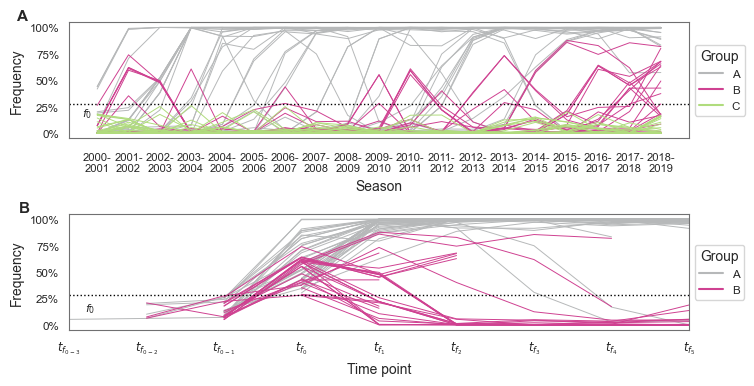

In [21]:
#plot time 
cpal = [base_color,sns.color_palette("PiYG")[0],sns.color_palette("PiYG")[4]]
group_order = sorted(smt["group"].unique())
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(8,4))
plt.subplots_adjust(hspace=0.65)

#prep dataframe
plot_freqs = smf.melt(id_vars="mutation", var_name="season", value_name="frequency").set_index(["mutation"]).join(smt.set_index("mutation")["group"]).reset_index()

#first plot
p1 = sns.lineplot(data=plot_freqs,ax=ax1, x="season", y="frequency", units="mutation", estimator=None, 
                  hue="group", hue_order=group_order, lw=.7, palette=cpal)
ax1.tick_params(axis="x", size=6)
ax1.axhline(y=sf0,c="black",linestyle=":", linewidth=1)
#ax1.axhline(y=f1,c="#8b8c89", linestyle=":", linewidth=1)
ax1.text(-0.5, sf0-0.12, '$f_0$',fontsize=8)
#ax1.text(-0.5, f1+0.05, '$f_1$',fontsize=8)
ax1.text(-2.55, 1.07, "A", fontsize=11,weight="bold")
ax1.legend (loc="center left", bbox_to_anchor=(1.0,0.5), title="Group")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Season")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

#redo tick labels
new_labels = [f"20{''.join(season[:2])}-\n20{''.join(season[2:])}" for season in seasons]
ax1.set_xticklabels(new_labels, size=8)

#second plot
p2  = sns.lineplot(ax=ax2, data=AB_freqs, x="time point", y="frequency", units="mutation", estimator=None, 
             hue="group",lw=0.7,  palette=cpal[:2])
ax2.set_xlim('$t_{f_{0-3}}$', '$t_{f_{5}}$') 
ax2.axhline(y=sf0,c="black",linestyle=":", linewidth=1)
#ax2.axhline(y=sf1,c="#8b8c89", linestyle=":", linewidth=1)
ax2.text(0.2, sf0-0.15, '$f_0$',fontsize=8)
#ax2.text(0.2, sf1+0.05,'$f_1$',fontsize=8)   
ax2.text(-0.65, 1.07, "B", fontsize=11,weight="bold")
ax2.legend (loc="center left", bbox_to_anchor=(1.0,0.5), title="Group")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Time point")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


#change colors of the axes spine because I'm very particular about my plots
for _,s in ax1.spines.items():
    s.set_color("#707071")
for _,s in ax2.spines.items():
    s.set_color("#707071")

### Mutation LBI distribution per season per analysis 

In [22]:
#get mutation LBI
lbi_file = os.path.join(main_dir, "mutation_lbi_100_2.csv")
redo = False #set to true if analysis needs to be redone

total_mutation_lbis = []
if not os.path.isfile(lbi_file) or redo:
    for a, fdir in analyses.items():
        seasons, mature_sequences,trees = get_sequences_trees_seasons(fdir)
        mutation_freqs = total_mutation_freqs[total_mutation_freqs["analysis"]==a].reset_index(drop=True)
        f0, f1 = determine_f0(mutation_freqs, seasons,[round(i,3) for i in np.arange(minor_cutoff, 0.3+0.01, 0.01)],[round(i,3) for i in np.arange(0.3,fixed_cutoff, 0.01)])
        mutation_timepoints, mutation_groups = time_point_assignment(mutation_freqs, f0, seasons)
        mutation_info = get_additional_info(mutation_freqs)
        mutation_season_seqs = get_mutation_seqs_season(mutation_freqs, mature_sequences)
        mutation_timeframes = get_mutation_timeframes(mutation_timepoints, seasons)
        mutation_nodes = get_mutation_nodes(mutation_timeframes, mutation_season_seqs, trees)
        mutation_lbis = collect_mutation_lbis(mutation_nodes, mutation_timeframes, mutation_groups, mutation_timepoints,mutation_info)
        #mutation_wlbis = collect_weigthed_mutation_lbis(mutation_nodes, mutation_timeframes, mutation_groups, mutation_timepoints,mutation_info)
        
        #add columns with analysis number
        mutation_lbis["analysis"] = a

        try:
            total_mutation_lbis = pd.concat([total_mutation_lbis, mutation_lbis])
        except:
            total_mutation_lbis = mutation_lbis
       
    total_mutation_lbis.to_csv(lbi_file)

else:
    total_mutation_lbis = pd.read_csv(lbi_file, dtype={'season': str}).drop(["Unnamed: 0"], axis=1) 

In [23]:
#remove mutations that we removed earlier,,,extra check
total_mutation_lbis = total_mutation_lbis[~total_mutation_lbis["mutation"].isin(mutations_to_remove)]

In [24]:
#get f0s values for each analysis 
f0s_f1 = []
for a in total_mutation_freqs["analysis"].unique():
    mutation_freqs = total_mutation_freqs[total_mutation_freqs["analysis"]==a]
    f0, f1 = determine_f0(mutation_freqs, seasons,[round(i,3) for i in np.arange(minor_cutoff, 0.3+0.01, 0.01)],[round(i,3) for i in np.arange(0.3,fixed_cutoff, 0.01)])
    f0s_f1.append([a,f0,f1])

f0s_f1 = pd.DataFrame.from_records(f0s_f1, columns=["analysis", "$f_0$", "$f_1$"])

/var/folders/9d/nj8tf3tj6gv6m18wpfp2c96m0000gn/T/ipykernel_3734/1084217006.py:9: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(ax=ax2, data=plot_f0f1 , x="analysis", y="frequency", hue="point",palette=cpal2, lw=0.7, linestyle="dashed")


Text(-18, 0.29, 'B')

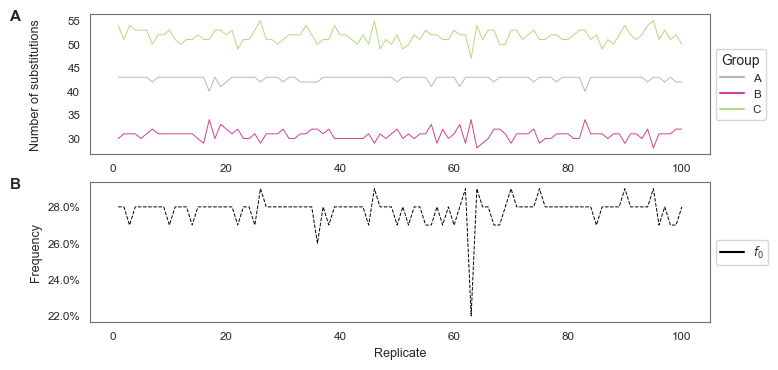

In [25]:
#plot group distribution against replicates
group_dist = total_mutation_lbis.groupby(["analysis", "mutation"])["group"].agg(pd.Series.mode).to_frame().reset_index().groupby(["analysis", "group"]).count().reset_index()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4))#, gridspec_kw={'height_ratios': [1,3]})
plt.subplots_adjust(hspace=0.2)
cpal2 = ["black","#8b8c89"]

plot_f0f1 = f0s_f1.drop("$f_1$", axis=1).melt(id_vars="analysis", var_name="point", value_name="frequency")
sns.lineplot(ax=ax2, data=plot_f0f1 , x="analysis", y="frequency", hue="point",palette=cpal2, lw=0.7, linestyle="dashed")
ax2.legend(loc="center left", bbox_to_anchor=(1.0,0.5))
sns.lineplot(ax=ax1, data=group_dist, x="analysis", y="mutation", hue="group", palette=cpal, lw=0.7)
ax1.legend(loc="center left", bbox_to_anchor=(1.0,0.5), title="Group")


ax1.set_ylabel("Number of substitutions", size=9)
ax2.set_ylabel("Frequency", size=9)
ax1.set_xlabel("")
ax2.set_xlabel("Replicate", size=9)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
fig.align_ylabels()

for _,s in ax1.spines.items():
    s.set_color("#707071")
for _,s in ax2.spines.items():
    s.set_color("#707071")
ax1.text(-18, 55, "A", fontsize=11,weight="bold")
ax2.text(-18, 0.29, "B", fontsize=11,weight="bold")

#sns.kdeplot(ax=ax2, data=plot_f0f1, x="frequency", hue="point", palette=cpal,)

### Statistical analysis of the mutation LBI distributions

In [26]:
#development purposes
lbi_frame=total_mutation_lbis

#### Mann Whitney U test at t<sub>0</sub>

Groups to compare:
- A (mutations that fix) vs. B & C (mutations that do not fix)
- C (mutations that never grow exponentially) vs. A & B (mutations that grow exponentially)
- A (mutations that fix) vs B (mutation that grow exponentially but do not fix)

Comparing two groups every time and the composition of the groups changes, not sure from what type of distribution the data comes from therefore non-parametric two group comparision > Mann-Whitney U  
- H<sub>0</sub>: the data from the different groups is drawn from the same distributions > the groups are the same
- H<sub>1</sub>: the data from the different groups is not drawn from the same distribution > the groups are different   

also splitting all comparison in epitope and non-epitope mutations

In [27]:
mutation_types = ["epitope", "non-epitope"]

mwu_t0 = []
for a in lbi_frame["analysis"].unique():
    #get subdf of the analysis and get correct time point #twobirdsonestone
    df = lbi_frame[lbi_frame["analysis"]==a].query("season==t0")
    for mt in mutation_types:
        subdf = df[df["epitope site"]==True] if mt=="epitope" else df[df["epitope site"]==False]
        
        uvalue, pvalue = stats.mannwhitneyu(subdf[subdf["group"]=="A"]["LBI"], subdf[subdf["group"]!="A"]["LBI"])
        mwu_t0.append([a, mt, "A vs. \nB & C", uvalue, pvalue, "accept" if pvalue>=0.05 else "reject"])
        uvalue, pvalue = stats.mannwhitneyu(subdf[subdf["group"]=="A"]["LBI"], subdf[subdf["group"]=="B"]["LBI"])
        mwu_t0.append([a, mt, "A vs. B", uvalue, pvalue, "accept" if pvalue>=0.05 else "reject"])
        uvalue, pvalue = stats.mannwhitneyu(subdf[subdf["group"]=="C"]["LBI"], subdf[subdf["group"]!="C"]["LBI"])
        mwu_t0.append([a, mt, "C vs. \nA & B", uvalue, pvalue, "accept" if pvalue>=0.05 else "reject"])

    #all mutations
    uvalue, pvalue = stats.mannwhitneyu(df[df["group"]=="A"]["LBI"], df[df["group"]!="A"]["LBI"])
    mwu_t0.append([a, "all", "A vs. \nB & C", uvalue, pvalue, "accept" if pvalue>=0.05 else "reject"])
    uvalue, pvalue = stats.mannwhitneyu(df[df["group"]=="A"]["LBI"], df[df["group"]=="B"]["LBI"])
    mwu_t0.append([a, "all", "A vs. B", uvalue, pvalue, "accept" if pvalue>=0.05 else "reject"])
    uvalue, pvalue = stats.mannwhitneyu(df[df["group"]=="C"]["LBI"], df[df["group"]!="C"]["LBI"])
    mwu_t0.append([a, "all", "C vs. \nA & B", uvalue, pvalue, "accept" if pvalue>=0.05 else "reject"])

mwu_t0 = pd.DataFrame.from_records(mwu_t0, columns=["analysis", "mutation type", "groups compared", "Mann-Whitney U-value", "p-value", "H0"])     

#### Mann Whitney U test at t<sub>f<sub>0</sub></sub>

Groups to compare (mutations in group C have no t<sub>f<sub>0</sub></sub>):
- A (mutations that fix) vs. B(mutation that grow exponentially but do not fix)

Comparing two groups every time and the composition of the groups changes, not sure from what type of distribution the data comes from therefore non-parametric two group comparision > Mann-Whitney U  
- H<sub>0</sub>: the data from the different groups is drawn from the same distributions > the groups are the same
- H<sub>1</sub>: the data from the different groups is not drawn from the same distribution > the groups are different   

also splitting all comparison in epitope and non-epitope mutations

In [28]:
mutation_types = ["all", "epitope", "non-epitope"]
#subgroup = ["all", "pop-up", "regular"]

mwu_tf0 = []
for a in lbi_frame["analysis"].unique():
    df = lbi_frame[lbi_frame["analysis"] == a] #get subdf of the analysis 
    
    subdf = df
    for mt in mutation_types:
        subsubdf = subdf[subdf["epitope site"]==True] if mt=="epitope" else subdf if mt=="all" else subdf[subdf["epitope site"]==False]
        uvalue, pvalue = stats.mannwhitneyu(subsubdf[subsubdf["group"]=="A"]["LBI"], subsubdf[subsubdf["group"]=="B"]["LBI"])
        mwu_tf0.append([a, mt, uvalue, pvalue, "accept" if pvalue>=0.05 else "reject"])

mwu_tf0 = pd.DataFrame.from_records(mwu_tf0, columns=["analysis", "mutation type", "Mann-Whitney U-value", "p-value", "H0"])     
  

#### Statistical results plot

In [29]:
### merge statistical results
stat_plot = []
for a in mwu_t0["analysis"].unique():
    #get the t0 mann whitney results
    amwu = mwu_t0[mwu_t0["analysis"]==a].drop(["Mann-Whitney U-value", "H0"], axis=1)
    amwu["time point"] = "$t_{0}$"
    try:
        stat_plot = pd.concat([stat_plot, amwu])
    except:
        stat_plot = amwu

    #get the tf0 mann whitney reuslts
    amwu = mwu_tf0[mwu_tf0["analysis"]==a].drop(["Mann-Whitney U-value", "H0"], axis=1)
    amwu["time point"] = "$t_{f_{0}}$"
    amwu["groups compared"] = "A vs. B"
    stat_plot = pd.concat([stat_plot, amwu])

In [30]:
#calculate support for each time point, group, mutation type, subgroup combo
support_values = []
for tp in stat_plot["time point"].unique():
    df = stat_plot[stat_plot["time point"]==tp]
    for g in df["groups compared"].unique():
        subdf = df[df["groups compared"]==g]
        for mt in subdf["mutation type"].unique():
            subsubdf = subdf[subdf["mutation type"]==mt]
            #for sg in subsubdf["subgroup"].unique():
            #    subsubsubdf = subsubdf[subsubdf["subgroup"]==sg]
            support = sum(p < 0.05 for p in subsubdf["p-value"].values)
            support_values.append([tp, g, mt, support])
support_values = pd.DataFrame.from_records(support_values, columns=["time point", "groups compared", "mutation type", "support"])                

In [31]:
#get data frame ready for plotting
support_values["time point"] = pd.Categorical(support_values["time point"], categories=["$t_{0}$", "$t_{f_{0}}$"])
support_values["mutation type"] = pd.Categorical(support_values["mutation type"], categories=["all", "epitope", "non-epitope"])
support_values["groups compared"] = pd.Categorical(support_values["groups compared"], categories=["A vs. \nB & C", "B vs. \nA & C", "C vs. \nA & B", "A vs. B"])
support_values = support_values.sort_values(["time point", "mutation type", "groups compared"]).set_index(["time point", "mutation type", "groups compared"])

In [32]:
#ditto
stat_plot["time point"] = pd.Categorical(stat_plot["time point"], categories=["$t_{0}$", "$t_{f_{0}}$"])
stat_plot["groups compared"] = pd.Categorical(stat_plot["groups compared"], categories=["A vs. \nB & C", "B vs. \nA & C",  "C vs. \nA & B", "A vs. B"])

stat_table = stat_plot.copy()
stat_plot = stat_plot.pivot(index=["analysis"], columns=["time point", "mutation type", "groups compared"], values="p-value").sort_values(by=["time point", "mutation type", "groups compared" ], axis=1)

In [33]:
#save files
stat_plot.to_csv(os.path.join(main_dir, "stats.csv"))
support_values.to_csv(os.path.join(main_dir, "supports.csv"))

Text(12.2, 108, '*(P value<0.05)')

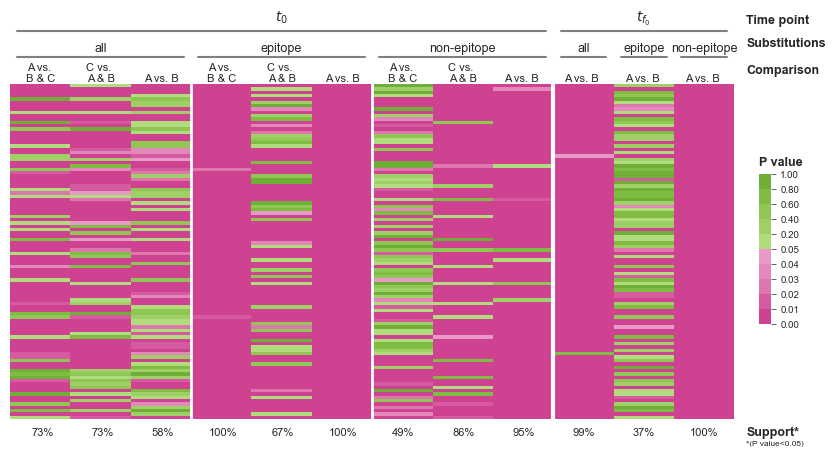

In [34]:
#plotter de plot 
def label_rows(ax, df):
    xpos = -0.15
    linepos = 0
    scale = 1.0/df.index.size

    for level in reversed(range(df.index.nlevels)):
        pos = df.index.size
        labels = [(k, sum(1 for i in g)) for k,g in itertools.groupby(df.index.get_level_values(level))]
        
        for label,rpos in labels:
            pos -= rpos
            lypos = (pos + 0.3 * rpos)*scale 
            if level == 0:
                ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes, size=9)
            else:
                ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes, size=7)

            if level!= range(df.index.nlevels)[-1]:
                add_vline(ax, pos*scale, -0.11,rpos*scale)
        
        xpos -= .08

def label_columns(ax, df):
    xpos = 1.005
    linepos = 0
    scale = 1./df.columns.size
    for level in reversed(range(df.columns.nlevels)):
        pos = df.columns.size
        labels = [(k, sum(1 for i in g)) for k,g in itertools.groupby(df.columns.get_level_values(level))]

        for label, rpos in reversed(labels):
            pos -= rpos
            lypos = (pos + rpos/2)*scale 
            
            if level == 0:# or level == 1: 
                if label.startswith("t"):
                    label = label.replace("t","$t_{") + "}$"
                    
                    if "f" in label:
                        label = label.replace("}$", "}}$").replace("f", "f_{")
                     #   label = label.s
                ax.text(lypos,xpos, label, ha='center', transform=ax.transAxes, size=10)

            elif level==1:
                ax.text(lypos,xpos, label, ha='center', transform=ax.transAxes, size=9)
            elif level ==2:
                if rpos > 1:
                    for i in range(1, rpos+1):
                        lypos = (pos + i)*scale -0.02
                        ax.text(lypos,xpos, label, ha='right', transform=ax.transAxes, size=8)
                else:
                    ax.text(lypos,xpos, label, ha='center', transform=ax.transAxes, size=8)

            #if level!= range(df.index.nlevels)[-1]:
            if level == 0:
                add_hline(ax, pos*scale, xpos*scale+1.06,rpos*scale)
            elif level == 1:
                add_hline(ax, pos*scale, xpos*scale+0.99,rpos*scale)

        xpos += .09

def add_support_values(ax, df):
    ypos = -0.05
    xpos = 0.045
    for i, row in df.iterrows():
        support = f'{row["support"]}%'
        ax.text(xpos,ypos, support, ha='center', transform=ax.transAxes, size=8)
        xpos += .083

#generate colormap
colors = []
for i, c in enumerate(sns.color_palette("PiYG", n_colors=34)[4:9] + list(sns.color_palette("PiYG", n_colors=34)[24:29])):
    # if i == 0 or i == len(sns.color_palette("PiYG", n_colors=34)[4:9] + list(sns.color_palette("PiYG", n_colors=34)[24:29]))-1:
    #     colors.append(c)
    # else:
    colors.extend([c,c])
pvalue_colmap = LinearSegmentedColormap.from_list(name="what the flu",
        colors=list(zip([0.0,0.01,0.01,0.02,0.02,0.03,0.03,0.04,0.04,0.05,0.05,0.20,0.20,0.40,0.40,0.6,0.6,0.8,0.8,1.0],
                    colors)))

#make the actual figure
fig = sns.clustermap(stat_plot, row_cluster=False,col_cluster=False,vmin=0, vmax=1.0,cmap=pvalue_colmap,
                     linewidths=0.001,figsize=(12,6))#,annot=plot_kruskal_lbi_annot, fmt='', 
                     #annot_kws={'verticalalignment': 'center','color':'white','fontsize':9})

#restyle row labeling 
fig.ax_heatmap.yaxis.set_ticks_position("left")
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10)
fig.ax_heatmap.set_yticks([])
#label_rows(fig.ax_heatmap, stat_plot)

#restyle column labeling
fig.ax_heatmap.xaxis.set_ticks_position("top")
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10)
fig.ax_heatmap.set_xticks([])
label_columns(fig.ax_heatmap, stat_plot)

add_support_values(fig.ax_heatmap, support_values)

fig.ax_row_dendrogram.set_visible(False)
fig.ax_col_dendrogram.set_visible(False)
fig.ax_heatmap.set(xlabel=None, ylabel=None)
plt.subplots_adjust(left=0.2)

space_before = [('$t_{0}$', 'epitope', 'A vs. \nB & C'), ('$t_{0}$', 'non-epitope', 'A vs. \nB & C'),('$t_{f_{0}}$', 'all', 'A vs. B')]
for i,col in enumerate(stat_plot.columns):

    if col in space_before:
        fig.ax_heatmap.axvline(i, color='white', lw=2)
        if '$t_{f_{0}}$' in col:
            fig.ax_heatmap.axvline(i, color='white', lw=3)

bounds = [0.0,0.01,0.02,0.03,0.04,0.05,0.2,0.4,0.6,0.8,1.0]#[0.0,0.05,1.0]
norm = BoundaryNorm(bounds, pvalue_colmap.N)
cb = mcp.ColorbarBase(fig.cax, cmap=pvalue_colmap, boundaries=bounds, ticks=bounds)
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=7)
#cb.set_label("p-value")

fig.ax_cbar.set_position((0.975, .43, .01, .25))
fig.ax_cbar.set_title("P value", size=9, loc="left", weight="bold")

fig.ax_heatmap.text(12.2,-18, "Time point", ha='left', size=9, weight="bold")
fig.ax_heatmap.text(12.2,-11, "Substitutions", ha='left', size=9, weight="bold")
fig.ax_heatmap.text(12.2,-3, "Comparison", ha='left', size=9, weight="bold")

fig.ax_heatmap.text(12.2,105, "Support*", ha='left', size=9, weight="bold")
fig.ax_heatmap.text(12.2,108, "*(P value<0.05)", ha='left', size=6)


### LBI distribution visualization

In [35]:
#get all combos
combos = {}
for i, row in stat_table.iterrows():
    a, mt, g, p, tp = row
    combo = "**".join([mt, g, tp]) #splitting this later
    try:
        combos[combo].append(a)
    except:
        combos[combo] = [a]

In [36]:
#collect the mutation LBIs of sig analysis per combo and create data frame
lbi_dists = []
for combo, a_list in combos.items():
    m, g, t = combo.split("**")
    groups = [i for i in g.replace("\n"," ").split(" ") if i in["A", "B", "C"]]
    
    for a in a_list:
        #get correct analysis file 
        df = total_mutation_lbis[total_mutation_lbis["analysis"]==a]

        #get correct time point
        if "t_{0}" in t:
            subdf = df.query("season==t0")
        else:
            subdf = df.query("season==tf0")

        #get correct mutation type
        if m == "epitope":
            subdf = subdf[subdf["epitope site"]==True]
        elif m =="non-epitope":
            subdf = subdf[subdf["epitope site"]==False]

        #get groups intereset
        subdf = subdf[subdf["group"].isin(groups)]

        for i, row in subdf.iterrows():
            lbi_dists.append([t,m,g,a,row["mutation"],row["group"],row["LBI"]])

lbi_dists = pd.DataFrame.from_records(lbi_dists, columns=["time point", "mutation type", "groups compared","analysis","mutation","group","LBI"])

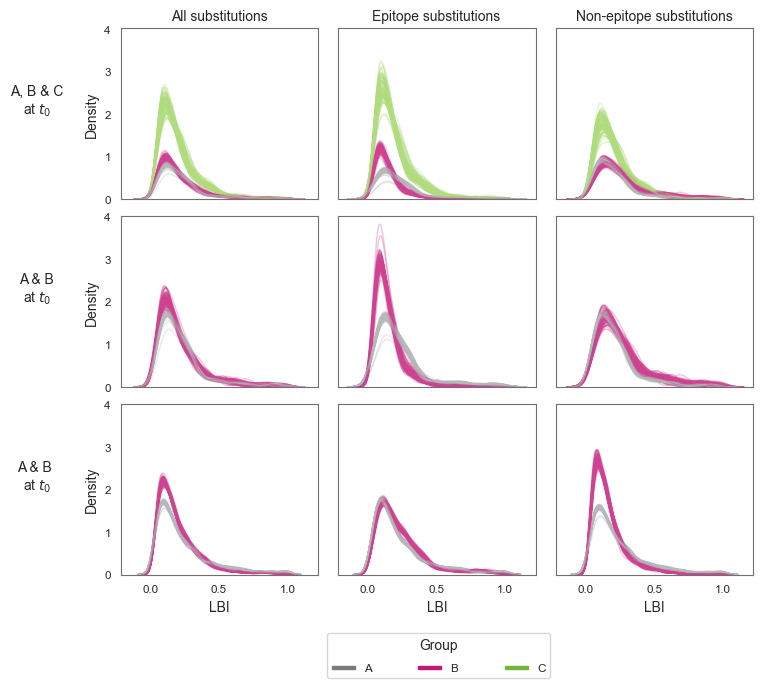

In [37]:
fig, axes = plt.subplots(3,3, figsize=(7,6),sharex=True, sharey=True)
fig.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.1)

cpal3 = ["#797a7a", sns.color_palette("PiYG",n_colors=10)[0],sns.color_palette("PiYG",n_colors=10)[-2]]

for k, t in enumerate(['$t_{0}$','$t_{f_{0}}$']):
    for i, g in enumerate(['A vs. \nB & C', 'A vs. B']):
        if t == '$t_{f_{0}}$' and i!=1:
            continue
        for j, m in enumerate(['all', 'epitope', 'non-epitope']):
            df = lbi_dists[(lbi_dists["time point"]==t)&(lbi_dists["mutation type"]==m)&(lbi_dists["groups compared"]==g)]
            go = group_order if g != "A vs. B" else group_order[:2]
            cp = cpal if g != "A vs. B" else cpal[:2]
            cp2 = cpal3 if g != "A vs. B" else cpal3[:2]
            for a  in df["analysis"].unique():
                subdf = df[df["analysis"]==a] 

                #for mut in subdf["mutation"].unique():
                #   subsubdf=subdf[subdf["mutation"]==mut]
                sns.kdeplot(ax=axes[k+i,j], data=subdf, x="LBI", hue="group", hue_order=go, palette=cp, lw=1, alpha=0.3, legend=False)
            #sns.kdeplot(ax=axes[k+i,j], data=df, x="LBI", hue="group", hue_order=go, palette=cp2)         

axes[0,0].text(0.5,4.2, "All substitutions", ha='center', size=10)
axes[0,1].text(0.5,4.2, "Epitope substitutions", ha='center', size=10)
axes[0,2].text(0.5,4.2, "Non-epitope substitutions", ha='center', size=10)

axes[0,0].text(-0.83, 2, "A, B & C\nat $t_{0}$", ha="center", size=10)
axes[1,0].text(-0.83, 2, "A & B\nat $t_{0}$", ha="center", size=10)
axes[2,0].text(-0.83, 2, "A & B \nat $t_{0}$", ha="center", size=10)

legend_handles = [Patch(color=cpal3[0], label="A"),Patch(color=cpal3[1], label="B"),Patch(color=cpal3[2], label="C") ]
fig.legend(handles=legend_handles, bbox_to_anchor=(0.68,-0.03), ncol=4, title="Group", labelspacing=1, handleheight=0.05, columnspacing=4)

for i in range(0,3):
    for j in range(0,3):
        for _,s in axes[i,j].spines.items():
            s.set_color("#707071")
